This notebook will detail the initial analysis of the outputs of the full stereomapper run on the set of 1.3 million compounds from the related databases stored in ReconXKG. Note, that the EnviPath and MetaCyc compounds are not included as of this run due to outdated mapping issues and license problems. 

Additionally, structures containing wildcard atoms are not included as they have been deemed out of scope of this project due to their difficult nature.

Analysis here will invovle getting some initial stats on the coverage of the pipeline's results, and possibly some data cleaning in preparation for comparison against the set of ReconXKG mappings / relationships

## Initial Analysis

In [13]:
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# first, read in the results database
db_path = Path("output_database.sqlite") # obtainable from manuscript additional files

# create connection
conn = sqlite3.connect(db_path)
# get a cursor
c = conn.cursor()

# check the expected tables are present
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
tables = [t[0] for t in tables]
print("Expected tables: ['clusters', 'relationships]")
print("Actual tables in database:", tables)

Expected tables: ['clusters', 'relationships]
Actual tables in database: ['clusters', 'relationships']


Both tables expected to be created are present, good start.

In [15]:
# now lets have an initial look at the clusters table, see what sort of data we have
df_clusters_peek = pd.read_sql_query("SELECT * FROM clusters LIMIT 5;", conn)
df_clusters_peek

,cluster_id,inchikey_first,identity_key_strict,is_undef_sru,is_def_sru,sru_repeat_count,sru_key,member_count,members_json,members_hash
0,1,AAAAGGGRHVKJPW,CCCCC/C=C\C/C=C\C/C=C\C/C=C\CCCCCCCCCCCCCCCC(=...,0,0,None,none,1,"[""slm:SLM:736507""]",db55be2239bd2eac03bb254a780c704ee87055d839e77b...
1,2,AAAAGYWRODJXSD,CCCCC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCCCCCCCCCCC...,0,0,None,none,1,"[""slm:SLM:496071""]",0830b68b759c58b051c0feb193175c757e5e5a1692ac11...
2,3,AAAAGYWRODJXSD,CCCCC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCCCCCCCCCCC...,0,0,None,none,1,"[""slm:SLM:491467""]",36e33cded4fa84438dc10a439001c7566b068adcf29343...
3,4,AAABALCCAVGCNQ,CC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCC(=O)O[...,0,0,None,none,1,"[""slm:SLM:512033""]",c995e07bef761cf6d20a89ff3ef8b262b590caf1403226...
4,5,AAABMNXUOFPYQK,C=C1C[C@](OC)([C@H](O)C(=O)N[C@H]2OCO[C@H]3[C@...,0,0,None,none,3,"[""chebi:CHEBI:80858"", ""kegg.compound:C17009"", ...",4cbda1ea6824f5b36c0cd005ca63f490be347642181d10...


All expected columns are present, each with the expected values. We can even see a case where a cluster has more than one member, indicating that the clustering algorithm performed as expected. Let's see the range of member counts we have in the dataset.

In [16]:
sql_range_member_counts = """
SELECT
    MIN(member_count) AS min_member_count,
    MAX(member_count) AS max_member_count,
    AVG(member_count) AS avg_member_count
FROM clusters;
"""

df_member_counts = pd.read_sql_query(sql_range_member_counts, conn)
df_member_counts

,min_member_count,max_member_count,avg_member_count
0,1,15,1.112457


From above, can see that the maximum amount of members in a cluster is 15, with the average member count essentially being 1. Perhaps, this was to be expected due to the strict nature of the stereomapper pipeline. Another possible factor for this maybe unexpected average value, is that structures in the represented database, may not reflect the exact structure they intend, so this may affect the expected identitiy clustering. This fact is highlighted in the study by Akhondi et al.,

In [17]:
# lets get the value counts of the different cluster sizes
sql_value_counts = """
SELECT
    member_count,
    COUNT(*) AS cluster_count
FROM clusters
GROUP BY member_count
ORDER BY member_count;
"""
df_value_counts = pd.read_sql_query(sql_value_counts, conn)

# calc percentages
total_clusters = df_value_counts["cluster_count"].sum()
df_value_counts["percentage"] = (df_value_counts["cluster_count"] / total_clusters) * 100
df_value_counts

,member_count,cluster_count,percentage
0,1,911453,92.259238
1,2,53627,5.428241
2,3,14788,1.496873
3,4,5578,0.564617
4,5,1652,0.167219
5,6,541,0.054761
6,7,199,0.020143
7,8,66,0.006681
8,9,13,0.001316
9,10,6,0.000607


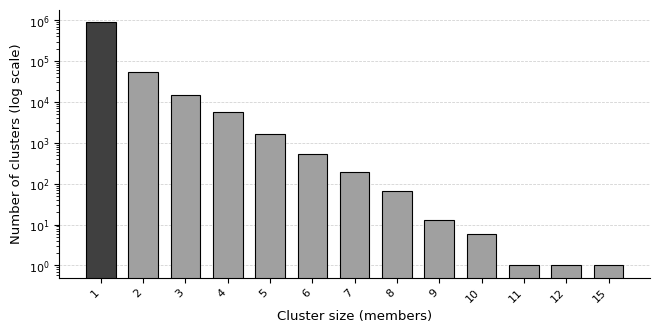

In [23]:
# ==== journal width constraint: 170 mm ====
TEXTWIDTH_MM = 165.0
INCH = 1/25.4
FIG_W = TEXTWIDTH_MM * INCH      # 6.69 in
FIG_H = 4.0                      # ~76 mm, safe under 225 mm

# ==== fonts for publication ====
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "pdf.fonttype": 42, "ps.fonttype": 42, "svg.fonttype": "none",

    # matched to your other figure's typography
    "font.size": 9.5,
    "axes.titlesize": 10.5,
    "axes.labelsize": 9.5,
    "xtick.labelsize": 8.0,
    "ytick.labelsize": 8.0,
})

# ---- data ----
sizes  = df_value_counts.iloc[:, 0].astype(int).to_numpy()
counts = df_value_counts.iloc[:, 1].astype(int).to_numpy()

order = np.argsort(sizes)
sizes, counts = sizes[order], counts[order]
pct = counts / counts.sum() * 100

# colour: singletons dark grey, others light grey
colors = ["#404040" if s == 1 else "#A0A0A0" for s in sizes]

# ==== figure ====
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))

x = np.arange(len(sizes))
ax.bar(x, counts, color=colors, width=0.7,
       edgecolor="black", linewidth=0.8)

# log scale for counts
ax.set_yscale("log")

# labels
ax.set_xlabel("Cluster size (members)")
ax.set_ylabel("Number of clusters (log scale)")

ax.set_xticks(x)
ax.set_xticklabels([str(s) for s in sizes], rotation=45, ha="right")

# grid + cosmetics
ax.yaxis.grid(True, linestyle="--", linewidth=0.55, alpha=0.6)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# keep layout clean inside 170 mm frame
fig.subplots_adjust(left=0.085, right=0.995, bottom=0.28, top=0.95)


plt.show()

As expected, the most common cluster member count is a value of 1, in line with the average calculated above. As member counts increase, the number of clusters representing this count decreases, a fact which was to be expected. Most clusters will sit in the range of having one to three members.